In [36]:
# Skip cell (weird vscode bug)

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import copy
import pygem_eb.processing.gridsearch_processing as gsproc
import pygem_eb.processing.gridsearch_plotting as gsplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# ===== GET RESULTS DICT =====
# gsproc.process_runs('long', sites='all')                # This function re-creates each individual run .pkl and thus takes ~60 minutes in series
result_dict = gsproc.get_result_dict(force_redo=False)     # Add force_redo=True to recompile the result dictionaries

In [4]:
# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['2024','snowdensity','winter','summer','snowdepth','annual']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims)

In [5]:
# ===== DEFINE LIST OF ERRORS TO PERFORM CALIBRATION =====
error_list = ['summer','winter','snowdensity','snowdepth']

One iteration takes 0.30 seconds


/trace/home/cvwilson/research/PyGEM-EB/pygem_eb/processing/gridsearch_processing.py:437: RuntimeWarning: Mean of empty slice
  if site == 'mean':


One iteration takes 0.21 seconds


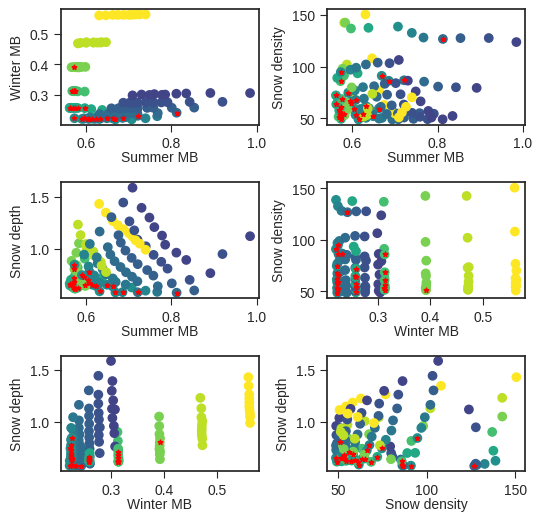

In [6]:
# ===== FIND PARETO FRONTS AND PLOT AN EXAMPLE =====
all_bootstrap_pareto, all_calib, all_valid, optima = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, error_list, return_validation=True, return_optima=True)
all_pareto_flat = list(set(list(itertools.chain(*all_bootstrap_pareto))))
gsplot.plot_pareto_fronts(error_list, result_dict, split=1)

In [12]:
all_bootstrap_pareto_seasonal = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, ['summer','winter'])
frequency_dict_seasonal, _ = gsproc.get_frequency(all_bootstrap_pareto_seasonal)

all_bootstrap_pareto_annual = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, ['annual'])
frequency_dict_annual, _ = gsproc.get_frequency(all_bootstrap_pareto_annual)

One iteration takes 0.05 seconds
One iteration takes 0.03 seconds


In [7]:
# ===== WEIGHT AND FIND THE BEST =====
best_by = gsproc.get_best_normalized(error_list, result_dict, prints=True, site='mean')
best = best_by[-1]

Weights:
    summer     winter snowdensity  snowdepth     best
         1          0          0          0      ('0.028', '2')
         0          1          0          0      ('0.02', '2.25')
         0          0          1          0      ('0.023', '3')
         0          0          0          1      ('0.018', '2.625')
      0.25       0.25       0.25       0.25      ('0.024', '2.25')


In [ ]:
# ===== COMPARE VALIDATION TO CALIBRATION =====
# gsplot.compare_calib_valid(error_list, all_calib, all_valid, savefig=True)

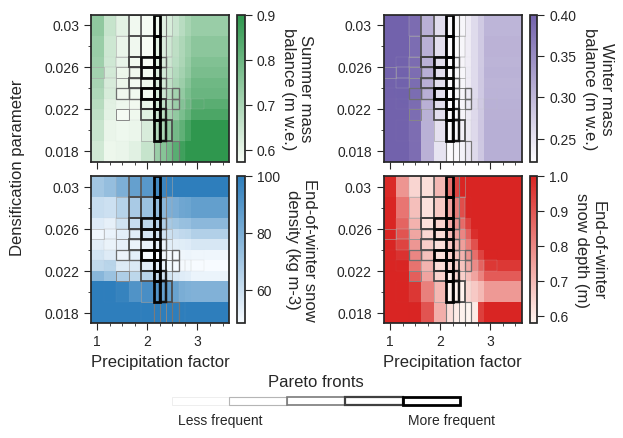

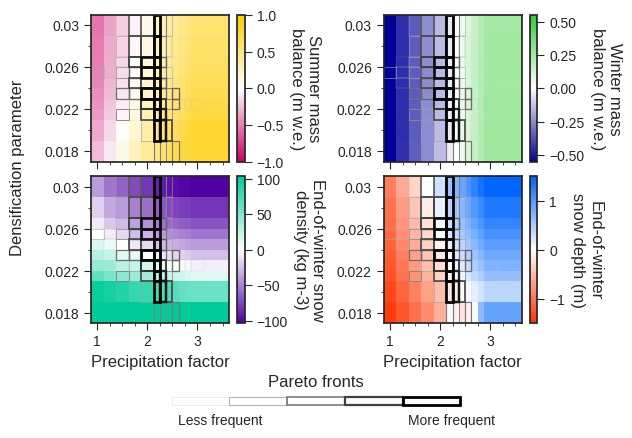

In [11]:
frequency_dict, _ = gsproc.get_frequency(all_bootstrap_pareto)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='MAE', optima=optima)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='ME', optima=optima)

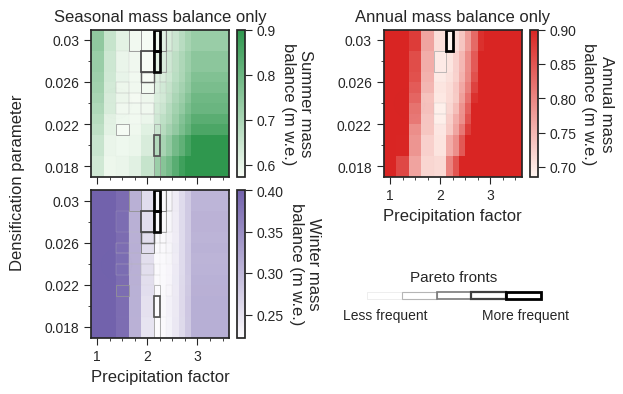

In [15]:
# 2x2 PLOT
fig = plt.figure(figsize=(6,4))
gs = mpl.gridspec.GridSpec(4,2, figure=fig, wspace=0.7, hspace=0.2)

# Generate subplots for seasonal 
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax_left = [ax1,ax2]
# Plot heatmap
fig, ax_left = gsplot.plot_pareto_heatmap(frequency_dict_seasonal, result_dict, ['summer','winter'], savefig=False, metric='MAE', figaxes = (fig, ax_left), legend=False)
# Labeling
ax_left[0].set_xticklabels(['','',''])
ax_left[0].set_title('Seasonal mass balance only', fontsize=12)
ax_left[1].set_title('')
ax_left[1].set_xlabel('Precipitation factor', fontsize=12)

# Generate subplot for annual
ax_right = fig.add_subplot(gs[0:2, 1])
# Plot heatmap
fig, ax_right = gsplot.plot_pareto_heatmap(frequency_dict_annual, result_dict, ['annual'], savefig=False, metric='MAE', figaxes = (fig, [ax_right]), legend=False)
# Labeling
ax_right[0].set_title('Annual mass balance only', fontsize=12)
ax_right[0].set_xlabel('Precipitation factor', fontsize=12)

cax = fig.add_axes([0.58,0.2,0.3,0.03])
cmap = mpl.colormaps['Grays']
norm =  mpl.colors.Normalize(vmin=0,vmax=5)
boundaries = [1,2,3,4,5]
for b in boundaries:
    alpha = 1 - (5 - b)/5
    rect = mpl.patches.Rectangle((b, 0), 1, 1, linewidth=alpha*2, edgecolor=cmap(norm(b)), facecolor='none')
    cax.add_patch(rect)
border = 0.1
cax.set_xlim(np.min(boundaries) - border, np.max(boundaries) + 1 + border)
cax.set_ylim(-0.3,1.3)
cax.axis('off')
cax.text(0.3, -2.7, 'Less frequent')
cax.text(4.3, -2.7, 'More frequent')
cax.set_title('Pareto fronts',fontsize=11)
fig.supxlabel('')

plt.savefig('/trace/group/rounce/cvwilson/Output/seasonal_annual_only_calibration.png', dpi=250, bbox_inches='tight')

In [ ]:
# ===== TRADEOFFS TIMESERIES=====
# gsplot.plot_difference_by_param(best, result_dict, plot_vars=error_list, savefig=True)

In [ ]:
# ===== PLOT 2024 PARETO FRONT VALIDATION =====
# gsplot.plot_pareto_2024(all_pareto_flat, result_dict, frequency_dict, best, savefig=True)

In [ ]:
# ===== TRADEOFFS TIMESERIES FOR ONE RUN TYPE =====
# gsplot.plot_tradeoffs_2024(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_annual(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_snowpits(result_dict, best_by[-1])

In [ ]:
# ===== MULTI-PANEL TRADEOFFS =====
# gsplot.plot_tradeoffs(result_dict,error_list,savefig=True)
# gsplot.plot_tradeoffs(result_dict,error_list,savefig=True,metric='ME')

In [ ]:
# ===== CALIBRATE ON ONE SITE =====
# gsplot.plot_heatmap_by_site(error_list, result_dict)
# gsplot.plot_best_by_site(error_list, result_dict)
# error_list_heatmap = error_list + ['weighted']
# gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='MAE', savefig=True)
# gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='ME', savefig=True)

In [ ]:
# ===== PLOT A SINGLE RUN =====
# gsplot.plot_best_seasonal(best, result_dict, savefig=True)
# gsplot.plot_best_2024(best, result_dict, savefig=True)
# gsplot.plot_best_snowpits(best_by[-1], result_dict, savefig=True)
# gsplot.plot_best_snowmass(best_by[-1], result_dict) 
# gsplot.plot_best_albedo(best, result_dict, savefig=True)

In [ ]:
# with open('/trace/group/rounce/cvwilson/Output/bias_correct/bias_correction_test.pkl', 'rb') as f:
#     mb_dict = pickle.load(f)
# gsplot.plot_bias_correction(mb_dict, True)

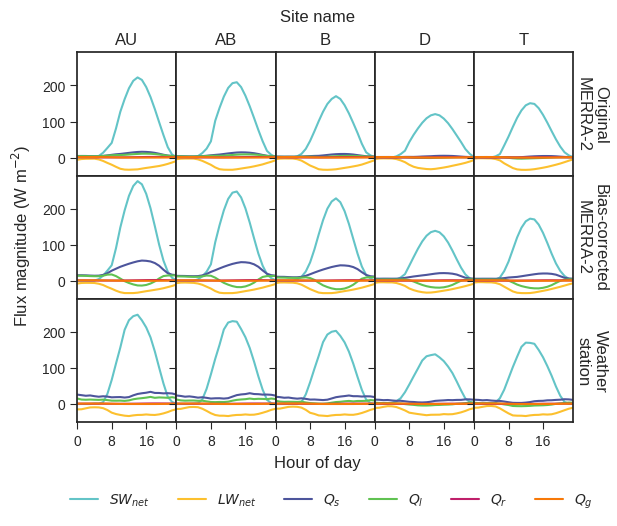

In [ ]:
gsplot.plot_fluxes(savefig=True)

In [ ]:
gsplot.find_precip_gradient()

In [16]:
sens_dict = {}
fp = '/trace/group/rounce/cvwilson/Output/sensitivity/'
def get_mb(fn):
    ds = xr.open_dataset(fn)
    internal_acc = ds.isel(time=-2).cumrefreeze.values
    summer_mb = ds.accum + ds.refreeze - ds.melt
    return summer_mb.sum().values - internal_acc
sens_dict['base'] = {}
sens_dict['base']['base'] = get_mb(fp + 'base_1.nc')
for var in ['kp','Boone-c5','lapserate','roughness-fresh-snow','roughness-aged-snow','roughness-ice','albedo-ground','ksp-BC','ksp-OC','ksp-dust']:
    sens_dict[var.replace('-','_')] = {}
    for direction in ['+20','-20']:
        sens_dict[var.replace('-','_')][direction] = get_mb(f'{fp}{var}_{direction}_1.nc') 


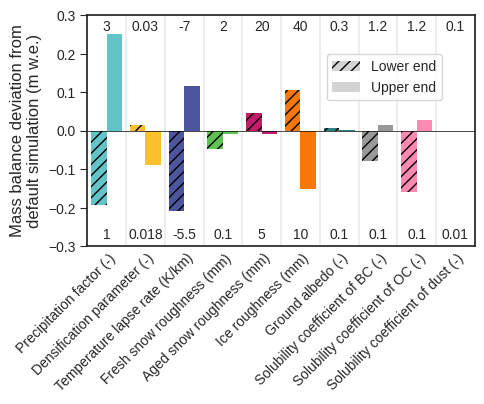

In [24]:
# with open('/trace/group/rounce/cvwilson/Output/sensitivity/sensitivity_test.pkl','wb') as f:
#     # sens_dict = pickle.load(f)
#     pickle.dump(sens_dict, f)
gsplot.plot_sensitivity(sens_dict, savefig=True)

In [ ]:
# ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
# site = 'B'
# ripe_dates = {}
# # if site == 'AU':
# #     ds,s,e = getds(f'~/research/Output/EB/Gulkana_2025_01_29_0.nc')
# # else:
# #     ds,s,e = getds(f'~/research/Output/EB/Gulkana_01_29_2024{site}_0.nc')
# ds = gsproc.get_any(result_dict, '0.022','2.5',site,'2024')
# fig, axes = plt.subplots(2,1,figsize=(5,3),sharex=True)
# (ax1,ax2) = axes

# if site =='D':
#     axes[0] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'], plot_ax=[axes[0]])[0] #,plot_firn=False)
# else:
#     axes[0] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],plot_ax=[axes[0]])[0]
# # Scatter initial heights of iButtons
# depths = np.array([f for f in ripe_dict[site]])
# heights = depths[-1] - depths
# start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
# ms=100
# if site == 'D':
#     heights += 700
# for c in range(len(heights)):
#     ax1.scatter(start[c],heights[c]/100,marker='>',color=colors[c],s=ms,edgecolor='k',linewidth=0.5,)
# ax1.scatter(np.nan,np.nan,color='gray',marker='>',label='iButtons buried',s=ms,edgecolor='k',linewidth=0.5,)

# # Scatter ripened dates for each sensor
# colors = ['#63c4c7','#fcc02e','#4D559C','#60C252','#BF1F6A']
# for c,depth in enumerate(ripe_dict[site]):
#     if site != 'B':
#         height = 150 - depth
#     else:
#         height = 270 - depth
#     if site == 'D':
#         height += 700
#     ax1.scatter(ripe_dict[site][depth],height/100,marker='^',s=ms,color=colors[c],edgecolor='k',linewidth=0.5,)
# ax1.scatter(np.nan,np.nan,marker='^',color='gray',s=ms,edgecolor='k',linewidth=0.5,label='iButtons ripe')
# ax1.set_ylabel('Height above\nice (m)',fontsize=12)
# ax1.legend()

# # Add lineplot of temperatures
# df = pd.read_csv('/trace/home/cvwilson/research/Data/iButtons_2024_B.csv',index_col=0)
# df.index = pd.to_datetime(df.index)
# df = df.resample('h').mean()
# for c,col in enumerate(df.columns):
#     values = df.loc[:list(ripe_dict[site].values())[c]]
#     ax2.plot(values.index, values[col].values,color=colors[c],label=list(ripe_dict[site])[c])
# leg = ax2.legend(title='Initial depth (cm)',loc='center',bbox_to_anchor=(1.2,0.4))
# leg.get_title().set_color('black')
# ax2.axhline(0,color='0.2',linewidth=0.8)
# ax2.tick_params(length=5)
# ax2.set_xticks(pd.date_range('2024-05-01','2024-08-01',freq='MS'))
# ax2.set_ylabel('Measured\ntemperature ($^{\circ}$C)',fontsize=12)

# pos1 = ax1.get_position()
# ax2.set_position([pos1.x0, ax2.get_position().y0, pos1.width, ax2.get_position().height])

# plt.savefig(gsproc.base_fp+'snow_temperature.png',dpi=200,bbox_inches='tight')
# plt.show()

In [ ]:
site_means = []
for site in ['ABB','B','BD','D','T']: # gsproc.sitedict['2024']:
    all_r2 = []
    for params in all_pareto_flat:
        dh_mod = result_dict[params[0]][params[1]][site]['dh_mod']
        dh_meas = result_dict[params[0]][params[1]][site]['dh_meas']
        ss_tot = np.sum((dh_meas - np.mean(dh_meas)) ** 2)
        ss_res = np.sum((dh_meas - dh_mod) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        all_r2.append(r_squared)
    site_means.append(np.mean(all_r2))
    print(site, 'Min',np.min(all_r2), 'Max', np.max(all_r2), 'Mean', np.mean(all_r2))
print('mean', np.mean(site_means))

ABB Min 0.7193424063486714 Max 0.9655512453165838 Mean 0.8796152311979929
B Min 0.4559579112285168 Max 0.9609789375822883 Mean 0.7618700005344528
BD Min 0.7773506300596236 Max 0.982694341327315 Mean 0.9112536426768553
D Min -0.6145884457278374 Max 0.9959106133557266 Mean 0.6547420148116273
T Min -0.6639294318369189 Max 0.7996387356780521 Mean 0.3087219494361326
mean 0.7032405677314121


In [ ]:
all_r2 = []
for site in ['ABB','B','BD','T']: # gsproc.sitedict['2024']:
    params = best
    dh_mod = result_dict[params[0]][params[1]][site]['dh_mod']
    dh_meas = result_dict[params[0]][params[1]][site]['dh_meas']
    ss_tot = np.sum((dh_meas - np.mean(dh_meas)) ** 2)
    ss_res = np.sum((dh_meas - dh_mod) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    all_r2.append(r_squared)
print(all_r2)
print(np.mean(all_r2), np.min(all_r2), np.max(all_r2))

[np.float64(0.9052294821920566), np.float64(0.8123619903891293), np.float64(0.9502936233527507), np.float64(0.48465543882343)]
0.7881351336893416 0.48465543882343 0.9502936233527507


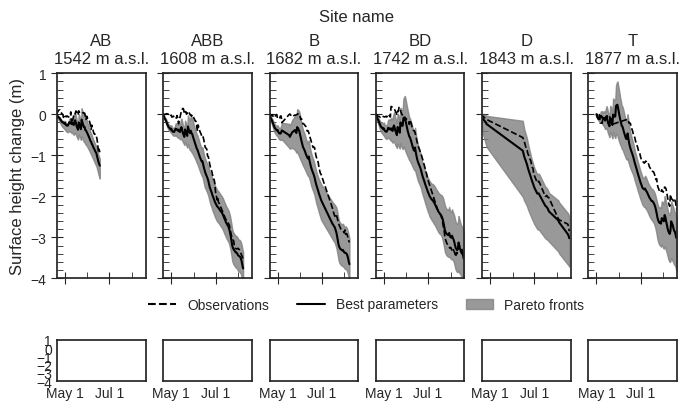

In [42]:
# gsplot.plot_best_2024_dh(best, result_dict)
gsplot.plot_pareto_2024_dh(result_dict, all_pareto_flat, best)